In [1]:
import sys
sys.path.append("..")

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import importlib
import plotting
from functools import partial

In [3]:
# dummy loss function
def loss_fn(sharpness, w):
    return (sharpness/2)*w**2
    # return np.abs(w)**sharpness

In [104]:
# quadratic function

def sim_traj(params, mode='sgd', bias_correction=False):
    sharpness, eta, w0, n_eps = params['sharpness'], params['eta'], params['w0'], params['n_eps'], 
    rms_lim, rms_beta, rms_init = params['rms_lim'], params['rms_beta'], params['rms_init'],
    
    ws = [w0]
    w = w0
    partial_loss_fn = partial(loss_fn, sharpness)
    grad_fn = jax.jit(jax.grad(partial_loss_fn))
    hess_fn = jax.jit(jax.hessian(partial_loss_fn))
    losses = [partial_loss_fn(w)]
    
    rms = rms_init
    eps = 10**-8
    
    for i in range(n_eps):
        w_grad = grad_fn(w)
        bc = 1. if bias_correction else (1-rms_beta**(i+1))
        rms = rms_beta * rms + (1-rms_beta)*w_grad**2
        
        if mode == 'sgd':
            w_new = w - eta * w_grad
        elif mode == 'rms':
            w_new = w - eta * w_grad / np.sqrt(rms*bc+eps)
        elif mode == 'rms-lb':
            w_new = w - eta * w_grad / np.maximum(np.sqrt(rms*bc+eps), rms_lim)
        elif mode == 'rms-ub':
            w_new = w - eta * w_grad / np.minimum(np.sqrt(rms*bc+eps), rms_lim)

        w = w_new
        losses.append(partial_loss_fn(w))
        ws.append(w)
    return np.array(ws), np.array(losses)


In [5]:
def viridis_xy(x, y):
    indices = np.arange(len(x) - 1)  # Segment indices
    norm = Normalize(vmin=indices.min(), vmax=indices.max())  # Normalize index range
    cmap = cm.viridis  # Use Viridis colormap
    
    # Create segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create the LineCollection, coloring based on index
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(indices)  # Use index order for coloring
    lc.set_linewidth(2)
    return lc

s 0 opt 0 w0:1.00E-01, w1:-1.30E-01, wf:+2.48E+10, elam2.0909090909090904
s 0 opt 1 w0:1.00E-01, w1:-3.06E+00, wf:+5.95E-01, elam2.0909090909090904
s 0 opt 2 w0:1.00E-01, w1:-1.09E-01, wf:+4.80E+00, elam2.090909090909091
s 0 opt 3 w0:1.00E-01, w1:-3.06E+00, wf:+2.10E+04, elam2.0909090909090904
s 1 opt 0 w0:1.00E-01, w1:-9.00E-02, wf:+2.66E-06, elam1.727272727272727
s 1 opt 1 w0:1.00E-01, w1:-3.06E+00, wf:+5.95E-01, elam1.727272727272727
s 1 opt 2 w0:1.00E-01, w1:-7.27E-02, wf:+1.48E-15, elam1.7272727272727273
s 1 opt 3 w0:1.00E-01, w1:-3.06E+00, wf:+4.89E-01, elam1.727272727272727


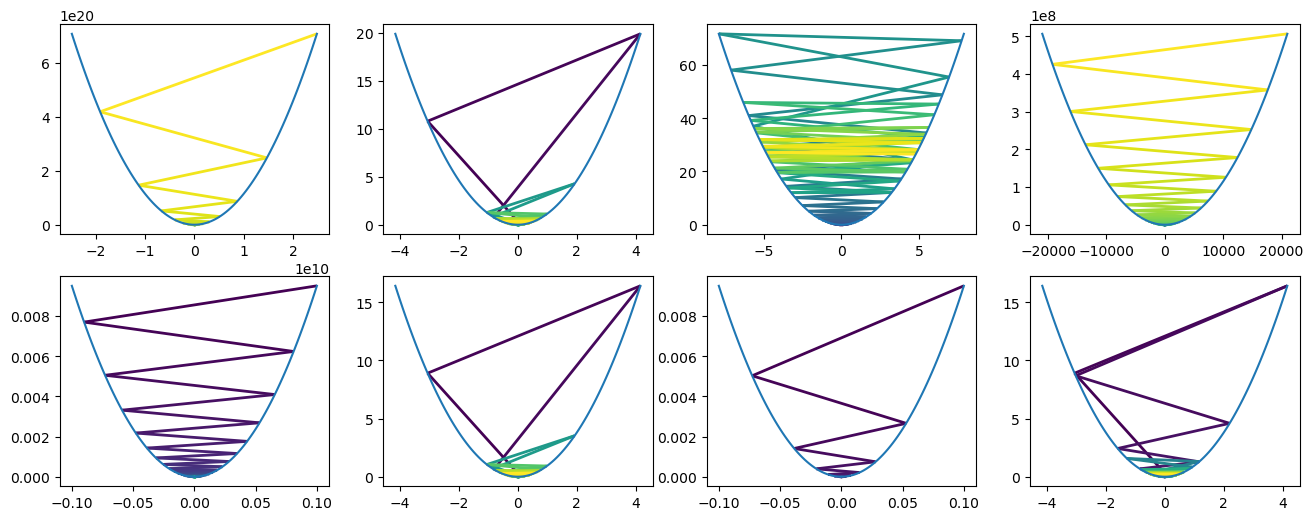

In [100]:

# loss_fn = lambda x: sharp/2*x**2

from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# quadratic loss function L = \lambda/2 X^2
def loss_fn(sharpness, w):
    return (sharpness/2)*w**2

fig, axs = plt.subplots(2, 4, figsize=(16, 6))
all_ws = []
for i, sharpness in enumerate([2.3, 1.9]):
    for j, opt in enumerate(['sgd', 'rms', 'rms-lb', 'rms-ub']):
        # sharpness = 2.
        w0 = 0.1
        j_factor = 1 if j != 2 else 10
        params = {
            'eta': 1. * j_factor, 
            'sharpness': sharpness, 
            'rms_lim': 1.1 * j_factor,
            'rms_beta': 0.9,
            'rms_init': (sharpness*w0)**2,
            # 'rms_init': 0.,
            'w0': w0,
            'n_eps': 100,
        }
        
        ws, losses = sim_traj(params, mode=opt)
        lc = viridis_xy(ws, losses)
        all_ws.append(ws)

        axs[i][j].add_collection(lc)
        axs[i][j].autoscale_view()

        xmax = max(np.abs(ws))
        xs = np.linspace(-xmax, xmax, 101)
        ys = loss_fn(sharpness, xs)
        axs[i][j].plot(xs, ys)
        
        print("s", i, "opt", j, f"w0:{ws[0]:.2E}, w1:{ws[1]:+.2E}, wf:{ws[-1]:+.2E}, elam{params['eta']*sharpness/params['rms_lim']}")
        
plt.show()

In [30]:
loss_fn = lambda x0, x1 : (x1)**4*(x0)**4 # x0 first layer, x1 second layer


zs_l = np.array(loss_fn(np.ravel(X), np.ravel(Y)))
print(zs_l.shape)
zs_g = np.array(jax.vmap(jax.grad(loss_fn, argnums=[0, 1]))(np.ravel(X), np.ravel(Y)))
print(zs_g.shape)
zs_h = np.array(jax.vmap(jax.hessian(loss_fn, argnums=[0, 1]))(np.ravel(X), np.ravel(Y)))
print(zs_h.shape)


(10201,)
(2, 10201)
(2, 2, 10201)


In [23]:
print(w0)
w1 = np.concatenate([w0[:, np.newaxis], 2*w0[:, np.newaxis]], axis=1)
print(w1)
print(np.max(w1, axis=1))

[-0.1 10. ]
[[-0.1 -0.2]
 [10.  20. ]]
[-0.1 20. ]


In [52]:
print(ws.shape)

(101, 2)


In [89]:
print(all_ws.shape)

(4, 11, 2)


In [109]:

def loss_fn(sharpness, inputs):
    dim = len(inputs.shape)
    return np.product(inputs, axis=dim-1)**sharpness

# Sim the trajectories
colors = ['r','orange',  'green', 'blue']

# for i, sharpness in enumerate([2.1, 1.9]):
for i, sharpness in enumerate([2.0]):    
    all_ws = []
    all_losses = []
    for j, opt in enumerate(['sgd', 'rms', 'rms-lb', 'rms-ub']):
        
        w0 = np.array([0.01, 1.])

        params = {
            'eta': 1.01, 
            'sharpness': sharpness, 
            'rms_lim': 10.0,
            'rms_beta': 0.9,
            # 'rms_init': jax.grad(partial_loss_fn)(w0)**2,
            'rms_init': 0.,
            'w0': w0,
            'n_eps': 10,
        }
        
        ws, losses = sim_traj(params, mode=opt, bias_correction=True)
        all_ws.append(ws)
        all_losses.append(losses)

    all_ws = np.array(all_ws)
    all_losses = np.array(all_losses)

with np.printoptions(suppress=True, precision=2):
    print(all_ws)

[[[ 0.01  1.  ]
  [-0.01  1.  ]
  [ 0.01  1.  ]
  [-0.01  1.  ]
  [ 0.01  1.  ]
  [-0.01  1.  ]
  [ 0.01  1.  ]
  [-0.01  1.  ]
  [ 0.01  1.  ]
  [-0.01  1.  ]
  [ 0.01  1.  ]]

 [[ 0.01  1.  ]
  [-3.18 -0.71]
  [ 0.01  2.49]
  [-0.12  2.49]
  [ 1.39  2.47]
  [-1.75  0.51]
  [-1.58 -0.16]
  [-1.56  0.02]
  [-1.56 -0.  ]
  [-1.56  0.  ]
  [-1.56 -0.  ]]

 [[ 0.01  1.  ]
  [ 0.01  1.  ]
  [ 0.01  1.  ]
  [ 0.01  1.  ]
  [ 0.    1.  ]
  [ 0.    1.  ]
  [ 0.    1.  ]
  [ 0.    1.  ]
  [ 0.    1.  ]
  [ 0.    1.  ]
  [ 0.    1.  ]]

 [[ 0.01  1.  ]
  [-3.18 -0.71]
  [ 0.01  2.49]
  [-0.12  2.49]
  [ 1.39  2.47]
  [-1.75  0.51]
  [-1.58 -0.16]
  [-1.56  0.02]
  [-1.56 -0.  ]
  [-1.56  0.  ]
  [-1.56 -0.  ]]]


nan nan nan nan


/tmp/ipykernel_1240501/1182028319.py:23: RuntimeWarning: invalid value encountered in sqrt
  w_new = w - eta * w_grad / np.sqrt(rms+eps)
/tmp/ipykernel_1240501/1182028319.py:26: RuntimeWarning: invalid value encountered in sqrt
  w_new = w - eta * w_grad / np.maximum(np.sqrt(rms+eps), rms_lim)
/tmp/ipykernel_1240501/1182028319.py:29: RuntimeWarning: invalid value encountered in sqrt
  w_new = w - eta * w_grad / np.minimum(np.sqrt(rms+eps), rms_lim)


ValueError: cannot convert float NaN to integer

/home/lawrencew/anaconda3/envs/jax/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


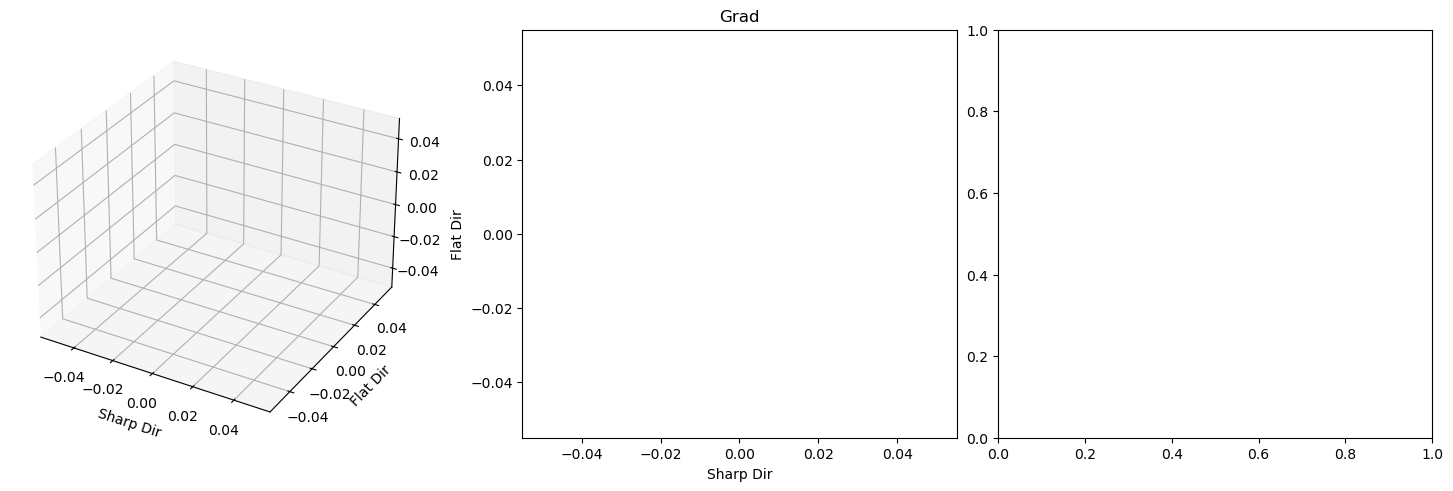

In [81]:
importlib.reload(plotting)

def loss_fn(sharpness, inputs):
    dim = len(inputs.shape)
    return np.product(inputs, axis=dim-1)**sharpness

# Sim the trajectories
colors = ['r','orange',  'green', 'blue']

# for i, sharpness in enumerate([2.1, 1.9]):
for i, sharpness in enumerate([2.0]):    
    partial_loss_fn = partial(loss_fn, sharpness)

    all_ws = []
    all_losses = []
    for j, opt in enumerate(['sgd', 'rms', 'rms-lb', 'rms-ub']):
        
        w0 = np.array([-0.01, 1.])

        params = {
            'eta': 1. , 
            'sharpness': sharpness, 
            'rms_lim': 1.01,
            'rms_beta': 0.9,
            'rms_init': jax.grad(partial_loss_fn)(w0),
            # 'rms_init': 0.,
            'w0': w0,
            'n_eps': 5,
        }
        
        ws, losses = sim_traj(params, mode=opt)
        all_ws.append(ws)
        all_losses.append(losses)

    all_ws = np.array(all_ws)
    all_losses = np.array(all_losses)
    
    xmin, xmax = np.min(all_ws[:, :, 0]), np.max(all_ws[:, :, 0])
    ymin, ymax = np.min(all_ws[:, :, 1]), np.max(all_ws[:, :, 1])
    print(xmin, xmax, ymin, ymax)
    
    fig, axs = plotting.vis_landscape(partial_loss_fn, xmin=xmin, xmax=xmax, 
                                            ymin=ymin, ymax=ymax, 
                                            yscale=True)
    all_gs = []
    all_hs = []
    all_es = []
    
    for i in range(len(all_ws)):
        ws = all_ws[i]
        losses = all_losses[i]
        print(ws, "\n", losses)
        
        zs_g = np.array(jax.vmap(jax.grad(partial_loss_fn))(ws))
        all_gs.append(zs_g)

        zs_h = np.array(jax.vmap(jax.hessian(partial_loss_fn))(ws))
        all_hs.append(np.array(zs_h))
        s, v = jax.vmap(jnp.linalg.eigh)(zs_h)  # why was this transposed?
        all_es.append(np.array(v[:, :, 1]))
        
    #     sharp_scale, flat_scale = np.mean(np.abs(all_gs[-1]), axis=0)
    #     grad_scale = sharp_scale / flat_scale
        grad_scale = 1.
        scaled_grads = all_gs[i].copy()
        scaled_grads[:, 1] *= grad_scale
        scaled_grads /= np.linalg.norm(scaled_grads, axis=1)[:, np.newaxis]
        
    #     sharp_scale, flat_scale = np.mean(np.abs(all_es[-1]), axis=0)
    #     hess_scale = sharp_scale / flat_scale
        hess_scale = 1.
        scaled_hess = all_es[i].copy()
        scaled_hess[:, 1] *= hess_scale
        scaled_hess /= np.linalg.norm(scaled_hess, axis=1)[:, np.newaxis]
        # scaled_hess *= np.sign(ws[:-1, 0])[:, np.newaxis]
    
        axs[0].plot(ws[:, 0], ws[:, 1], np.array(losses), c=colors[i], linewidth=2, alpha=0.7, zorder=1)
        axs[1].quiver(ws[:, 0], ws[:, 1], -scaled_grads[:, 0], -scaled_grads[:, 1], color=colors[i], scale=20.)
        axs[2].quiver(ws[:, 0], ws[:, 1], scaled_hess[:, 0], scaled_hess[:, 1], color=colors[i], scale=40.)
    


Eigvecs, scaled by 0 for clarity


/tmp/ipykernel_6368/3145868894.py:28: RuntimeWarning: divide by zero encountered in divide
  scaled_grads /= np.linalg.norm(scaled_grads, axis=1)[:, np.newaxis]
/tmp/ipykernel_6368/3145868894.py:28: RuntimeWarning: invalid value encountered in divide
  scaled_grads /= np.linalg.norm(scaled_grads, axis=1)[:, np.newaxis]


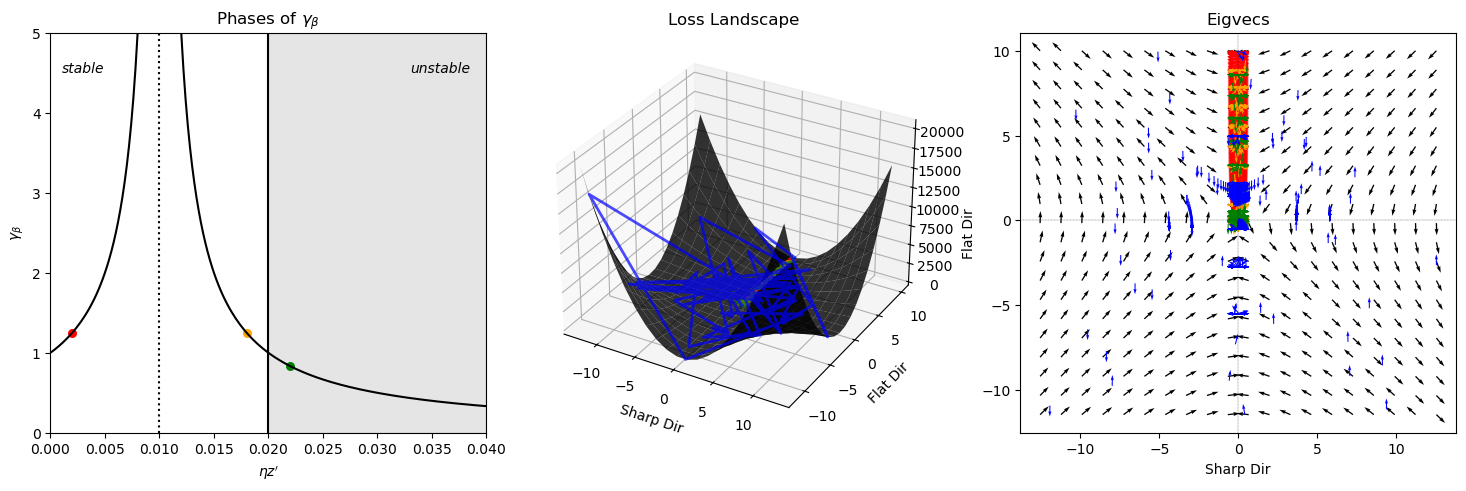

In [8]:
# realistic LL, opt trajectory
w0 = np.array([-0.1, 10.])

fig = plt.figure(figsize=plt.figaspect(0.33), layout='constrained')
# fig = plt.figure()
ax_b = fig.add_subplot(1, 3, 1,)
ax_l = fig.add_subplot(1, 3, 2, projection='3d', computed_zorder=False)
# ax_g = fig.add_subplot(1, 4, 3,)
ax_h = fig.add_subplot(1, 3, 3,)
axs = [ax_l, None, ax_h]
colors = ['r','orange',  'green', 'blue']
    
    # Realistic LL, quiver plot with steps in optim marked
importlib.reload(plotting)
xm = max(np.abs(np.min(ws[:, 0])), np.abs(np.max(ws[:, 0])))
fig, axs = plotting.vis_landscape_lgh_q(loss_fn, xmin=1.*-xm, xmax=1.*xm, 
                                        ymin=1.*np.min(ws[:, 1]), ymax=1.*np.max (ws[:, 1]), 
                                        yscale=True, fig=fig, axs=axs, do_g=False)

for i in range(len(etas)):
    ws = all_ws[i]
    losses = all_losses[i]
    
    sharp_scale, flat_scale = np.mean(np.abs(all_gs[-1]), axis=0)
    grad_scale = sharp_scale / flat_scale
    scaled_grads = all_gs[i].copy()
    scaled_grads[:, 1] *= grad_scale
    scaled_grads /= np.linalg.norm(scaled_grads, axis=1)[:, np.newaxis]

#     sharp_scale, flat_scale = np.mean(np.abs(all_es[-1]), axis=0)
#     hess_scale = sharp_scale / flat_scale
    hess_scale = 77
    scaled_hess = all_es[i].copy()
    scaled_hess[:, 1] *= hess_scale
    scaled_hess /= np.linalg.norm(scaled_hess, axis=1)[:, np.newaxis]
    scaled_hess *= np.sign(ws[:-1, 0])[:, np.newaxis]

    axs[0].plot(ws[:-1, 0], ws[:-1, 1], np.array(losses), c=colors[i], linewidth=2, alpha=0.7, zorder=1)
#     axs[1].quiver(ws[:-1, 0], ws[:-1, 1], -scaled_grads[:, 0], -scaled_grads[:, 1], color=colors[i], scale=20.)
    axs[2].quiver(ws[:-1, 0], ws[:-1, 1], scaled_hess[:, 0], scaled_hess[:, 1], color=colors[i], scale=40.)
    
k = 100.
fx = lambda x: np.abs((1-x**2)/(1-(k+1/k)*x+x**2))
xs = np.linspace(0., 0.04, 201)
ys = fx(xs)
# ax_g.remove()
ax_b.plot(xs, ys, c='k')
# ax = plt.gca()
ax_b.set_ylim(-0., 5)
ax_b.set_xlim(0.0, 0.04)
# ax_b.axhline(y=1, c='k', linestyle='dotted')
ax_b.fill_between(x=np.linspace(0, 1/k, 100), y1=0, y2=5, color='r', alpha=0.0)
ax_b.fill_between(x=np.linspace(1/k, 2/k, 100), y1=0, y2=5, color='r', alpha=0.0)
ax_b.fill_between(x=np.linspace(2/k, 0.04, 100), y1=0, y2=5, color='k', alpha=0.1)
ax_b.set_xlabel(r"$\eta z'$")
ax_b.set_ylabel(r"$\gamma_\beta$")

ax_b.axvline(x=1/k, c='k', linestyle='dotted')
ax_b.axvline(x=2/k, c='k', )

ax_l.set_title("Loss Landscape")
ax_b.set_title(r"Phases of $\gamma_\beta$")

ax_b.text(0.001, 4.5, 'stable', style='italic')
ax_b.text(0.033, 4.5, 'unstable', style='italic')

for eta_i, eta in enumerate(etas):
    this_x = eta*2
    ax_b.scatter(x=this_x, y=fx(this_x), c=colors[eta_i], marker='o', s=30)

plt.show()


In [52]:
loss_fn = lambda x0, x1 : (x1)**4*(x0)**4 # x0 first layer, x1 second layer


[1.2002133e+03 1.1992532e+03 1.1944624e+03 1.1707461e+03 1.0577832e+03
 6.1489105e+02 3.7576976e-01 3.7529925e-01 3.7482992e-01 3.7436169e-01
 3.7389469e-01 3.7342888e-01 3.7296414e-01]


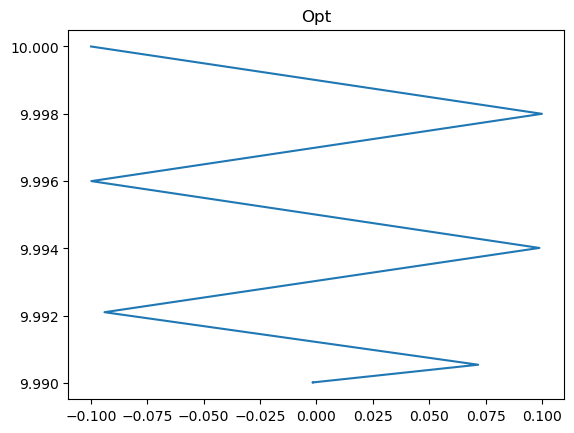

In [70]:
w0 = np.array([-0.1, 10.])

eta = 0.005
ws = [w0]
grads = []
sharps = []
eigvs = []

losses = []

for i in range(n_iters[eta_i]):
    w_old = ws[-1]
    loss = loss_fn(w_old[0], w_old[1])
    losses.append(loss)
    w_grad = np.array(jax.grad(loss_fn, argnums=(0, 1))(w_old[0], w_old[1]))
    grads.append(w_grad)
    hess = np.array(jax.hessian(loss_fn, argnums=(0, 1))(w_old[0], w_old[1]))
    s, v = np.linalg.eigh(hess)
    sharps.append(s[1])
    eigvs.append(v[:, 1])
#     print(2/s[1], w_old, w_grad)
    w_new = w_old - eta*w_grad # manually selected to be just above EoS with Sharp ~ 500000 so EoS ~ 0.000004
    ws.append(np.array(w_new))

ws = np.array(ws)
grads = np.array(grads)
sharps = np.array(sharps)
eigvs = np.array(eigvs)
print(sharps)
fig, ax = plt.subplots(1, 1)
ax.plot(ws[:, 0], ws[:, 1])
ax.set_title("Opt")
plt.show()


Eigvecs, scaled by 142 for clarity


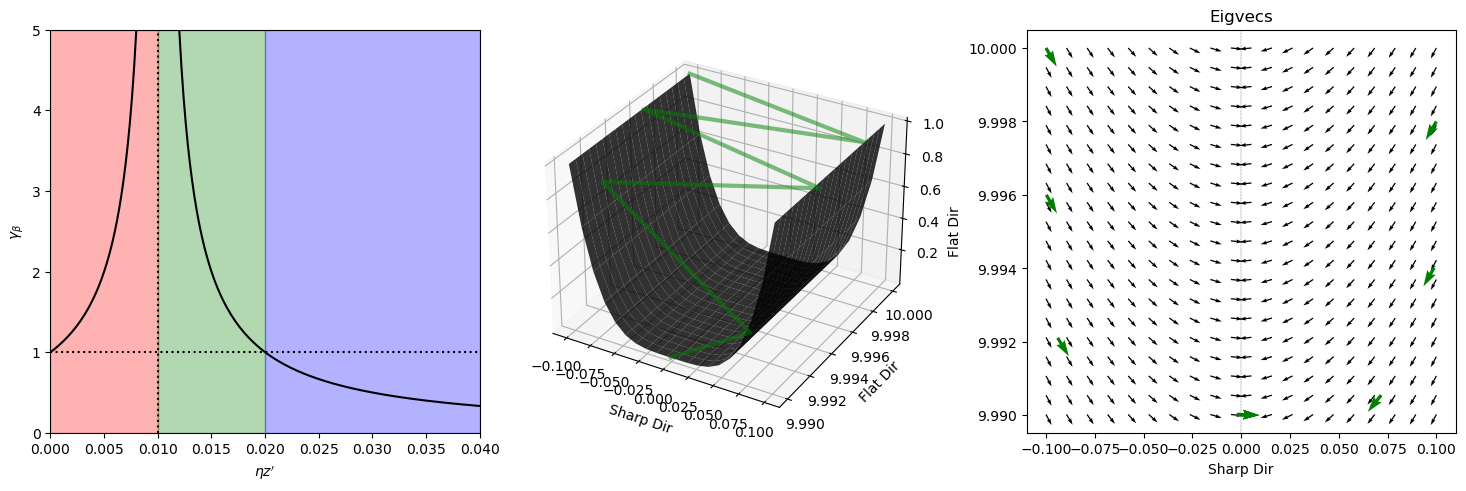

In [71]:
# realistic LL, opt trajectory
w0 = np.array([-0.1, 10.])

fig = plt.figure(figsize=plt.figaspect(0.33), layout='constrained')
# fig = plt.figure()
ax_b = fig.add_subplot(1, 3, 1,)
ax_l = fig.add_subplot(1, 3, 2, projection='3d', computed_zorder=False)
# ax_g = fig.add_subplot(1, 4, 3,)
ax_h = fig.add_subplot(1, 3, 3,)
axs = [ax_l, ax_g, ax_h]
# etas = [0.0099, 0.001, 0.0102]
# n_iters = [70, 50, 13]
etas = [0.005]
n_iters = [10]
colors = ['green', 'r', 'blue']
all_ws = []
all_sgs = []
all_shs = []
all_losses = []
all_gs = []
all_es = []
all_ss = []

for eta_i, eta in enumerate(etas):
    ws = [w0]
    grads = []
    sharps = []
    eigvs = []
# eta = 0.0099
# eta = 0.001
# eta = 0.0105

    losses = []

    for i in range(n_iters[eta_i]):
        w_old = ws[-1]
        loss = loss_fn(w_old[0], w_old[1])
        losses.append(loss)
        w_grad = np.array(jax.grad(loss_fn, argnums=(0, 1))(w_old[0], w_old[1]))
        grads.append(w_grad)
        hess = np.array(jax.hessian(loss_fn, argnums=(0, 1))(w_old[0], w_old[1]))
        s, v = np.linalg.eigh(hess)
        sharps.append(s[1])
        eigvs.append(v[:, 1])
    #     print(2/s[1], w_old, w_grad)
        w_new = w_old - eta*w_grad # manually selected to be just above EoS with Sharp ~ 500000 so EoS ~ 0.000004
        ws.append(np.array(w_new))

    ws = np.array(ws)
    grads = np.array(grads)
    sharps = np.array(sharps)
    eigvs = np.array(eigvs)
    all_ws.append(ws)
    all_gs.append(grads)
    all_ss.append(sharps)
    all_es.append(eigvs)
    all_losses.append(losses)
    
    # Realistic LL, quiver plot with steps in optim marked
importlib.reload(plotting)
xm = max(np.abs(np.min(ws[:, 0])), np.abs(np.max(ws[:, 0])))
fig, axs = plotting.vis_landscape_lgh_q(loss_fn, xmin=1.*-xm, xmax=1.*xm, 
                                        ymin=1.*np.min(ws[:, 1]), ymax=1.*np.max (ws[:, 1]), 
                                        yscale=True, fig=fig, axs=axs, do_g=False)

for i in range(len(etas)):
    ws = all_ws[i]
    losses = all_losses[i]
    
    sharp_scale, flat_scale = np.mean(np.abs(all_gs[-1]), axis=0)
    grad_scale = sharp_scale / flat_scale
    scaled_grads = all_gs[i].copy()
    scaled_grads[:, 1] *= grad_scale
    scaled_grads /= np.linalg.norm(scaled_grads, axis=1)[:, np.newaxis]

    sharp_scale, flat_scale = np.mean(np.abs(all_es[-1]), axis=0)
    hess_scale = sharp_scale / flat_scale
    scaled_hess = all_es[i].copy()
    scaled_hess[:, 1] *= hess_scale
    scaled_hess /= np.linalg.norm(scaled_hess, axis=1)[:, np.newaxis]
    scaled_hess *= np.sign(ws[:-1, 0])[:, np.newaxis]

    axs[0].plot(ws[:-1, 0], ws[:-1, 1], np.array(losses), c=colors[i], linewidth=3, alpha=0.5, zorder=1)
#     axs[1].quiver(ws[:-1, 0], ws[:-1, 1], -scaled_grads[:, 0], -scaled_grads[:, 1], color=colors[i], scale=20.)
    axs[2].quiver(ws[:-1, 0], ws[:-1, 1], scaled_hess[:, 0], scaled_hess[:, 1], color=colors[i], scale=20.)
k = 100.
fx = lambda x: np.abs((1-x**2)/(1-(k+1/k)*x+x**2))
xs = np.linspace(0., 0.04, 201)
ys = fx(xs)
# ax_g.remove()
ax_b.plot(xs, ys, c='k')
# ax = plt.gca()
ax_b.set_ylim(-0., 5)
ax_b.set_xlim(0.0, 0.04)
ax_b.axhline(y=1, c='k', linestyle='dotted')
ax_b.fill_between(x=np.linspace(0, 1/k, 100), y1=0, y2=5, color='r', alpha=0.3)
ax_b.fill_between(x=np.linspace(1/k, 2/k, 100), y1=0, y2=5, color='g', alpha=0.3)
ax_b.fill_between(x=np.linspace(2/k, 0.04, 100), y1=0, y2=5, color='b', alpha=0.3)
ax_b.set_xlabel(r"$\eta z'$")
ax_b.set_ylabel(r"$\gamma_\beta$")

# ax.axvline(x=0, c='k', linestyle='--')
ax_b.axvline(x=1/k, c='k', linestyle='dotted')
# ax.axvline(x=2/k, c='k', linestyle='--')
# fig.delaxes(ax_g)
# ax_b.change_geometry(1,3,1)
# ax_l.change_geometry(1,3,2)
# ax_h.change_geometry(1,3,3)

# plt.draw()
# plt.tight_layout()
# print(fx(1), fx(0.5), fx(2), fx(9.9), fx(1000))
plt.show()
# print(np.min(ws[:, 1]))